#### Importazione delle librerie

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight

In [48]:
# Fissa il seed per numpy
np.random.seed(42)

# Fissa il seed per TensorFlow
tf.random.set_seed(42)

### Analisi esplorativa

In [49]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
)

In [50]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [52]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [53]:
missing_data = data.isnull().sum()
print(f"Colonne \t  null \n{missing_data}")

Colonne 	  null 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


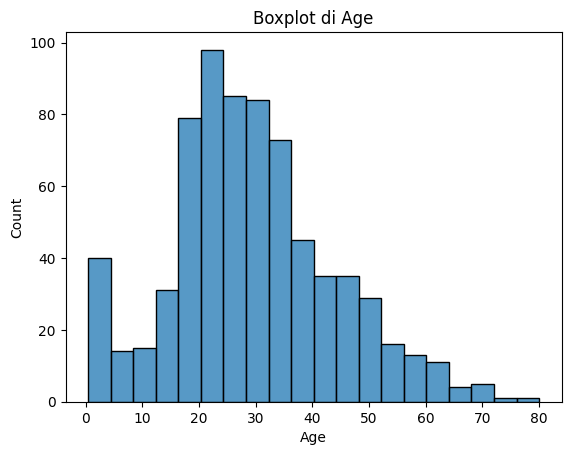

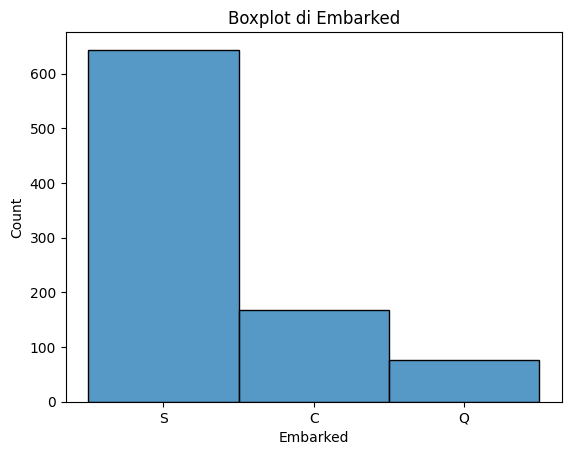

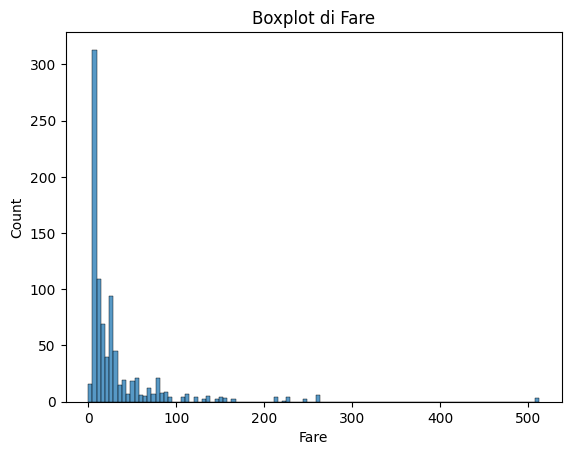

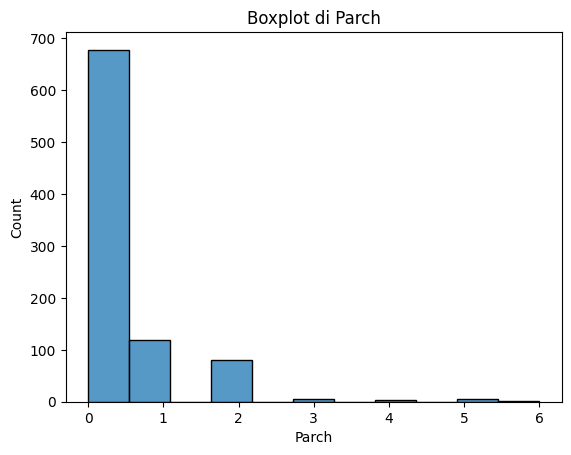

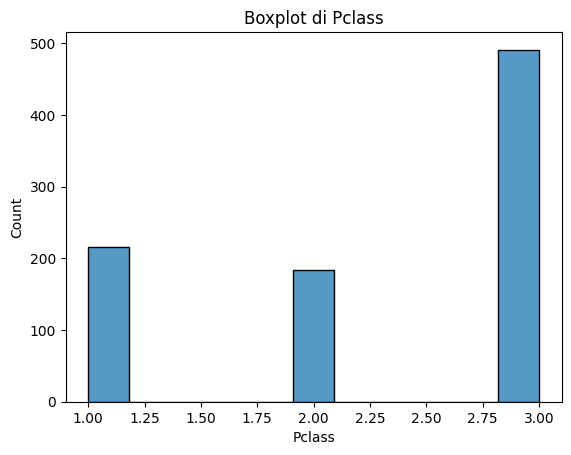

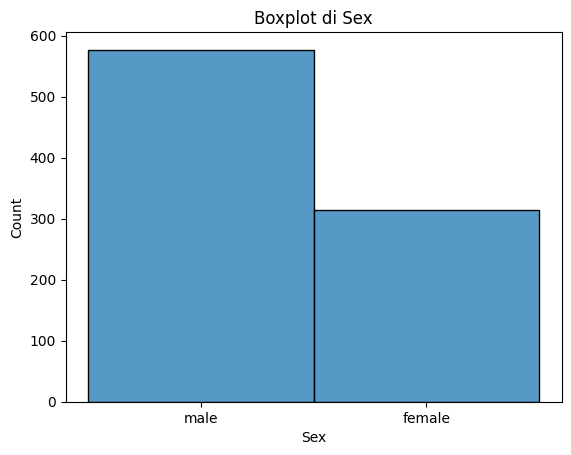

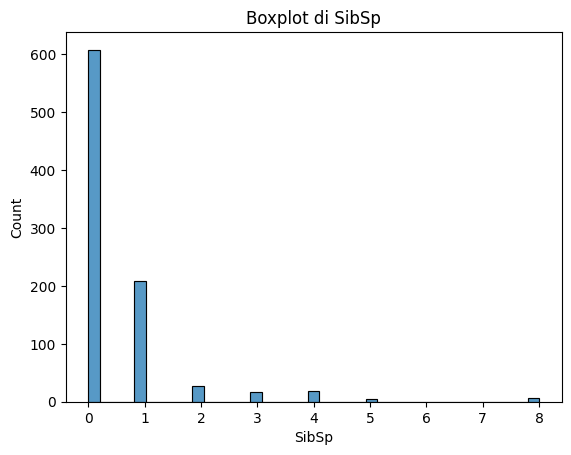

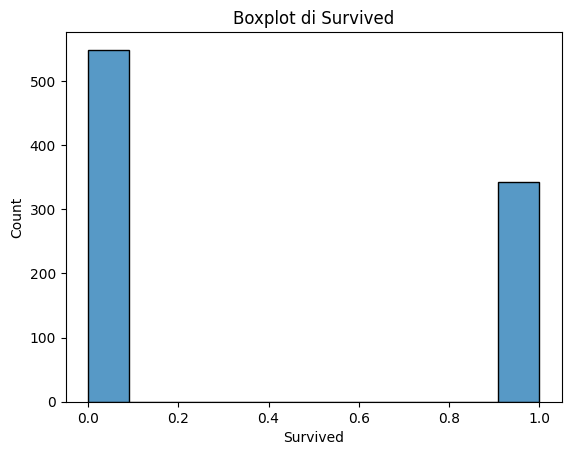

In [54]:
cols_to_plot = data.columns.difference(["PassengerId", "Ticket", "Cabin", "Name"])

for col in cols_to_plot:
    plt.figure()  # nuova figura per ogni colonna
    sns.histplot(x=data[col])
    plt.title(f"Boxplot di {col}")
    plt.show()

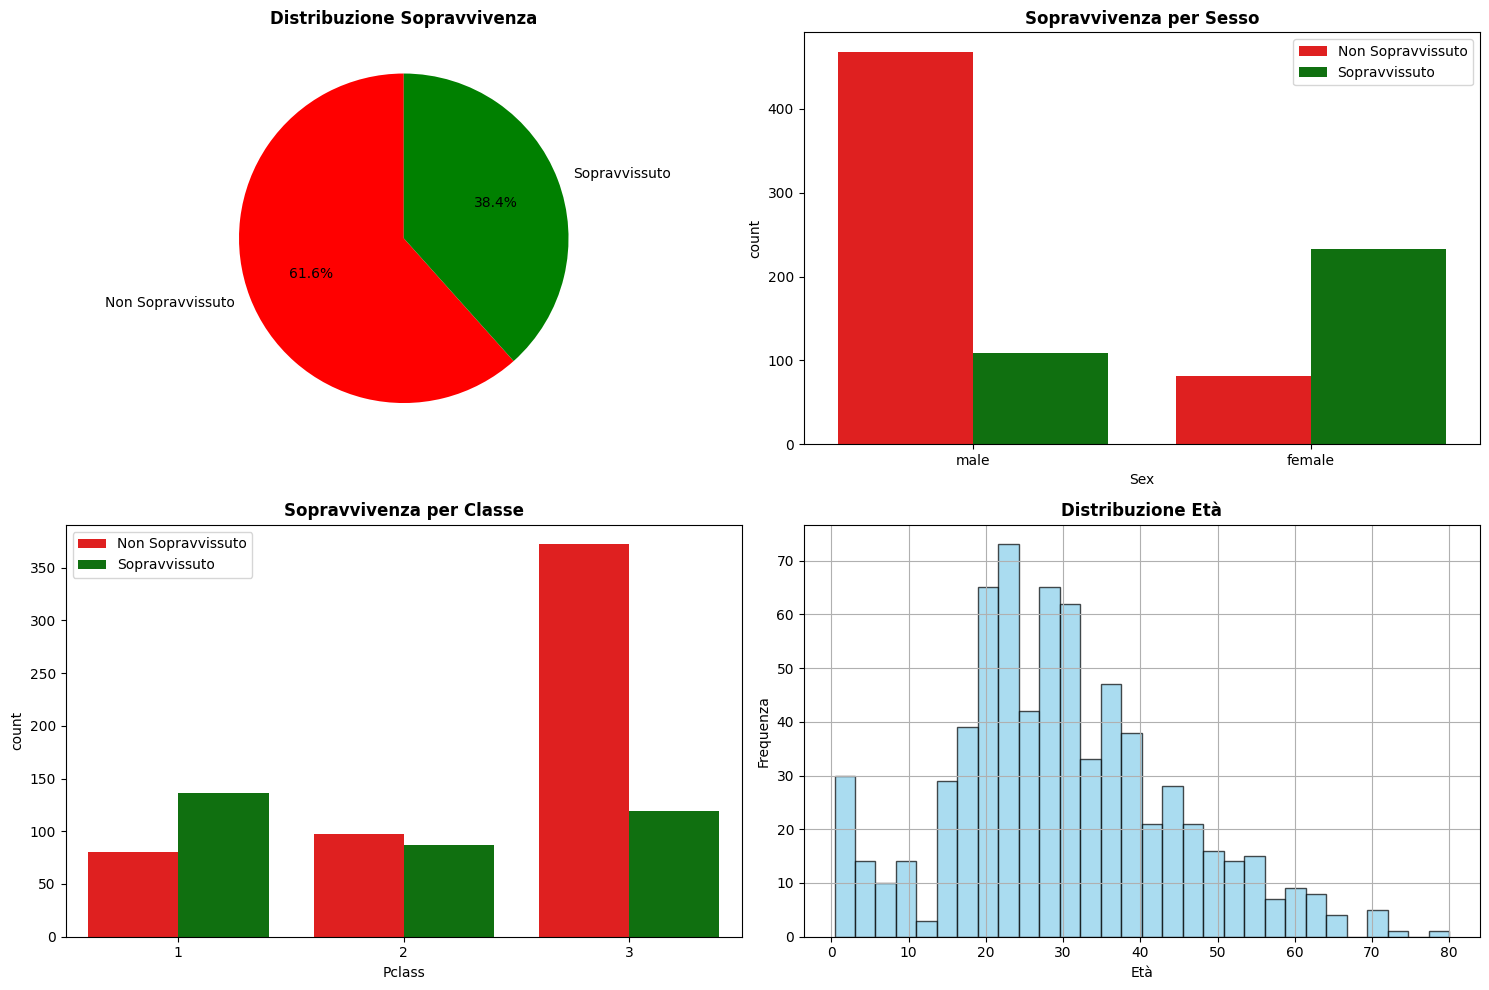

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

survival_counts = data["Survived"].value_counts()
axes[0, 0].pie(
    survival_counts.values,
    labels=["Non Sopravvissuto", "Sopravvissuto"],
    autopct="%1.1f%%",
    startangle=90,
    colors=["red", "green"],
)
axes[0, 0].set_title("Distribuzione Sopravvivenza", fontsize=12, fontweight="bold")

sns.countplot(
    data=data, x="Sex", hue="Survived", ax=axes[0, 1], palette=["red", "green"]
)
axes[0, 1].set_title("Sopravvivenza per Sesso", fontsize=12, fontweight="bold")
axes[0, 1].legend(["Non Sopravvissuto", "Sopravvissuto"])

sns.countplot(
    data=data, x="Pclass", hue="Survived", ax=axes[1, 0], palette=["red", "green"]
)
axes[1, 0].set_title("Sopravvivenza per Classe", fontsize=12, fontweight="bold")
axes[1, 0].legend(["Non Sopravvissuto", "Sopravvissuto"])

data["Age"].hist(bins=30, alpha=0.7, ax=axes[1, 1], color="skyblue", edgecolor="black")
axes[1, 1].set_title("Distribuzione Età", fontsize=12, fontweight="bold")
axes[1, 1].set_xlabel("Età")
axes[1, 1].set_ylabel("Frequenza")

plt.tight_layout()
plt.show()

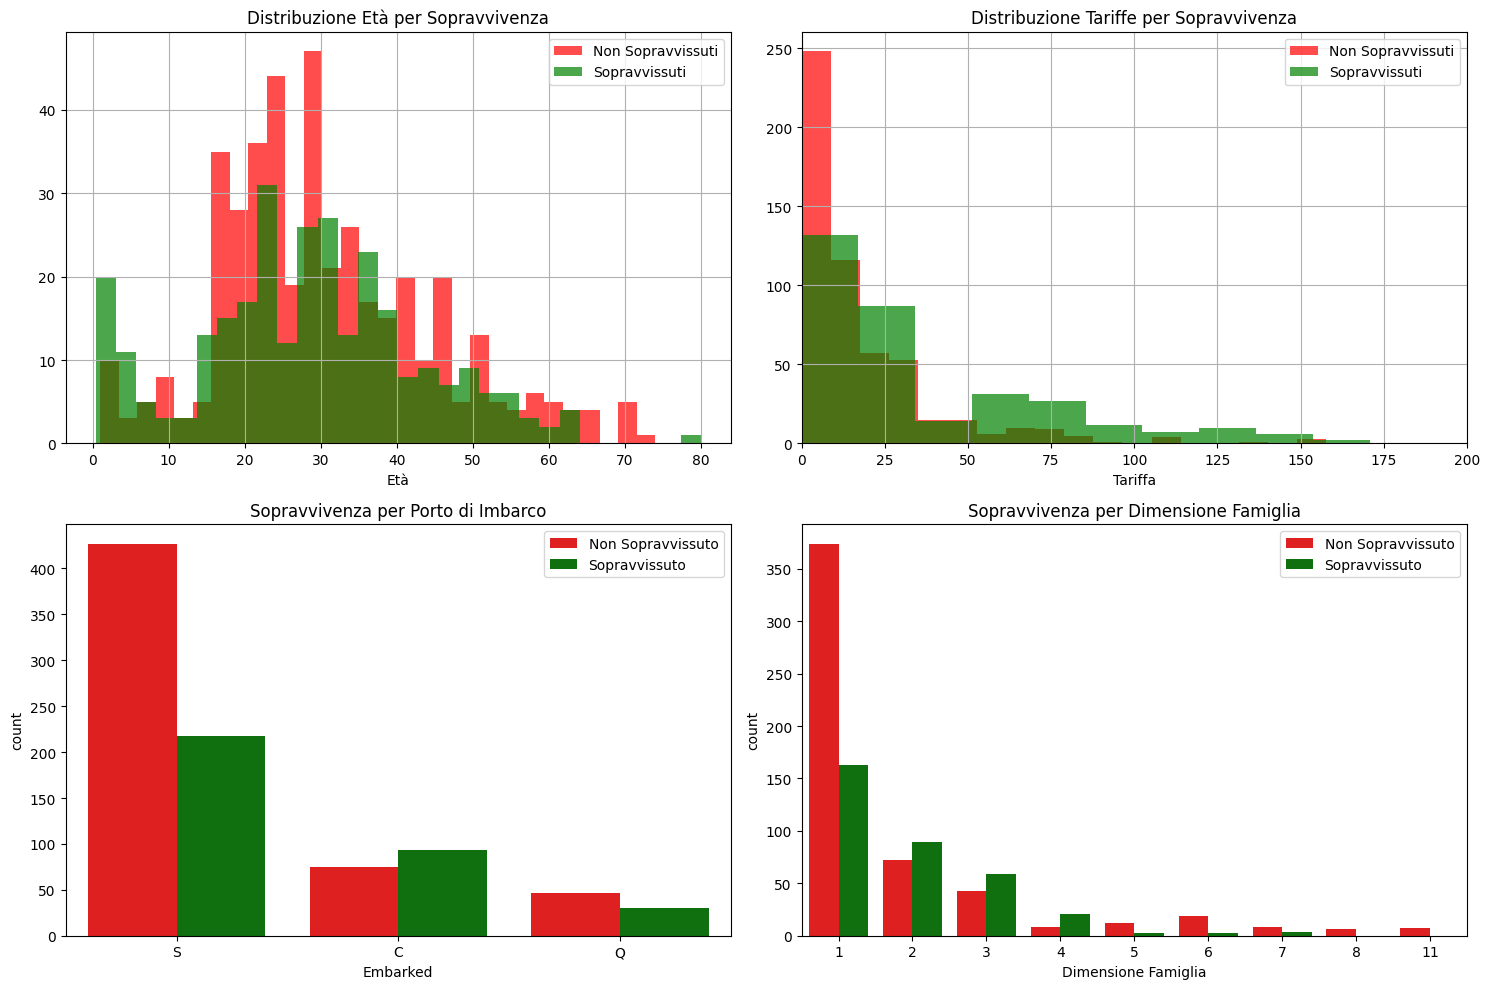

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribuzione età per sopravvivenza
data[data["Survived"] == 0]["Age"].hist(
    bins=30, alpha=0.7, ax=axes[0, 0], color="red", label="Non Sopravvissuti"
)
data[data["Survived"] == 1]["Age"].hist(
    bins=30, alpha=0.7, ax=axes[0, 0], color="green", label="Sopravvissuti"
)
axes[0, 0].set_title("Distribuzione Età per Sopravvivenza")
axes[0, 0].legend()
axes[0, 0].set_xlabel("Età")

# Distribuzione tariffe per sopravvivenza
data[data["Survived"] == 0]["Fare"].hist(
    bins=30, alpha=0.7, ax=axes[0, 1], color="red", label="Non Sopravvissuti"
)
data[data["Survived"] == 1]["Fare"].hist(
    bins=30, alpha=0.7, ax=axes[0, 1], color="green", label="Sopravvissuti"
)
axes[0, 1].set_title("Distribuzione Tariffe per Sopravvivenza")
axes[0, 1].legend()
axes[0, 1].set_xlabel("Tariffa")
axes[0, 1].set_xlim(0, 200)

# Porto di imbarco
sns.countplot(
    data=data, x="Embarked", hue="Survived", ax=axes[1, 0], palette=["red", "green"]
)
axes[1, 0].set_title("Sopravvivenza per Porto di Imbarco")
axes[1, 0].legend(["Non Sopravvissuto", "Sopravvissuto"])

# Dimensione famiglia (SibSp + Parch)
data["FamilySize"] = data["SibSp"] + data["Parch"] + 1
sns.countplot(
    data=data, x="FamilySize", hue="Survived", ax=axes[1, 1], palette=["red", "green"]
)
axes[1, 1].set_title("Sopravvivenza per Dimensione Famiglia")
axes[1, 1].legend(["Non Sopravvissuto", "Sopravvissuto"])
axes[1, 1].set_xlabel("Dimensione Famiglia")

plt.tight_layout()
plt.show()

Dall’analisi emerge chiaramente che la maggior parte delle persone non è sopravvissuta. Tuttavia, è evidente come le donne rappresentino la maggioranza tra i sopravvissuti.
Inoltre, la classe sociale ha avuto un ruolo importante nelle probabilità di sopravvivenza: chi apparteneva alla prima o seconda classe aveva maggiori possibilità di salvarsi.
Anche la dimensione del nucleo familiare ha influito: infatti, chi viaggiava con una famiglia composta da 2-4 persone aveva una probabilità più alta di sopravvivere.
Al contrario di chi viaggiava da solo.

### Pre-Processing

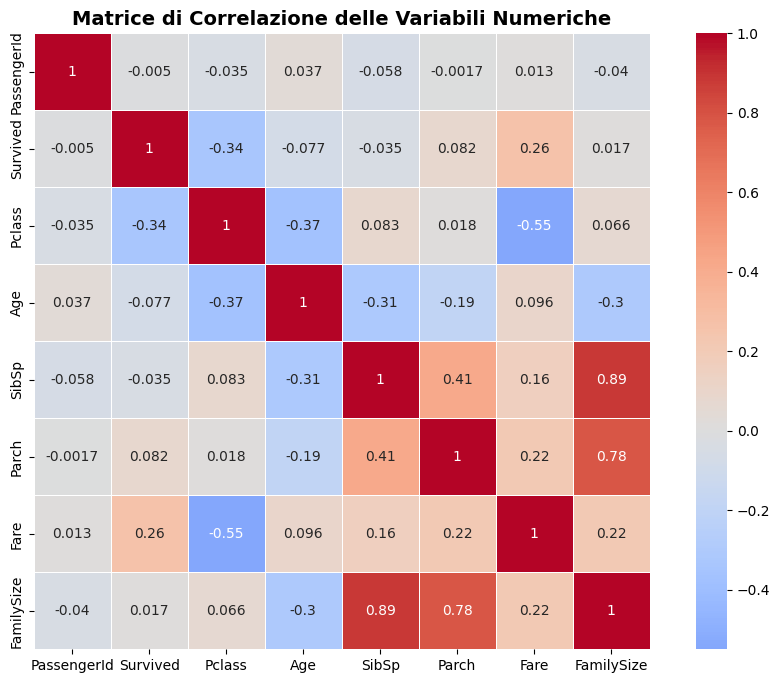

In [57]:
plt.figure(figsize=(12, 8))
numeric_columns = data.select_dtypes(["int64", "float64"]).columns
correlation_matrix = data[numeric_columns].corr()
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
)
plt.title(
    "Matrice di Correlazione delle Variabili Numeriche", fontsize=14, fontweight="bold"
)
plt.show()

Forte correlazione tra la grandezza della famiglia e il numero di genitori/figli o fratelli/cognati presenti sulla nave.

In [58]:
data["Age"].fillna(data["Age"].median(), inplace=True)
data["Embarked"].fillna(data["Embarked"].mode()[0], inplace=True)

C:\Users\Utente\AppData\Local\Temp\ipykernel_16496\411677293.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)
C:\Users\Utente\AppData\Local\Temp\ipykernel_16496\411677293.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

Per gestire i valori mancanti nel dataset, abbiamo applicato strategie diverse in base alla natura delle variabili. I valori mancanti della colonna Age, essendo una variabile numerica continua, sono stati sostituiti con la mediana, in modo da ridurre l'influenza di eventuali outlier. Per la colonna Embarked, invece, essendo una variabile categorica che indica il porto di imbarco, i valori mancanti sono stati riempiti con la moda, ovvero il valore più frequente. Questi interventi garantiscono una gestione coerente dei dati mancanti senza alterare in modo significativo la distribuzione originale delle variabili.

In [59]:
data["IsAlone"] = (data["FamilySize"] == 1).astype(int)

In [60]:
le = LabelEncoder()
data["Sex"] = le.fit_transform(data["Sex"])

data = pd.get_dummies(data, columns=["Embarked"], prefix="Embarked")
data = pd.get_dummies(data, columns=["Pclass"], prefix="Pclass")

In [61]:
data.head()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,FamilySize,IsAlone,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,2,0,False,False,True,False,False,True
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,2,0,True,False,False,True,False,False
2,3,1,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,1,False,False,True,False,False,True
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,2,0,False,False,True,True,False,False
4,5,0,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,1,1,False,False,True,False,False,True


### Divisione in Feature e Target e splitting in train/test

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    int32  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  FamilySize   891 non-null    int64  
 11  IsAlone      891 non-null    int32  
 12  Embarked_C   891 non-null    bool   
 13  Embarked_Q   891 non-null    bool   
 14  Embarked_S   891 non-null    bool   
 15  Pclass_1     891 non-null    bool   
 16  Pclass_2     891 non-null    bool   
 17  Pclass_3     891 non-null    bool   
dtypes: bool(6), float64(2), int32(2), int64(5), object

In [63]:
feature = data.select_dtypes(["int64", "float64", "int32", "bool"]).columns
target = ["Survived"]

X = data[feature].drop(["Survived"], axis=1)
y = data[target[0]]

In questa cella selezioniamo le variabili indipendenti (feature) e la variabile dipendente (target) per l'addestramento del modello.  
- Vengono selezionate solo le colonne di tipo numerico (`int64`, `float64`, `int32`) e booleano.  
- La colonna `Survived` (variabile target) viene separata dal resto delle feature.  
- `X` conterrà quindi tutte le feature numeriche/booleane escluse `Survived`.  
- `y` conterrà solo la colonna `Survived`, ovvero ciò che vogliamo predire.

In [64]:
print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (891, 14)
y: (891,)


In [65]:
X.head()

,PassengerId,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,1,22.0,1,0,7.2500,2,0,False,False,True,False,False,True
1,2,0,38.0,1,0,71.2833,2,0,True,False,False,True,False,False
2,3,0,26.0,0,0,7.9250,1,1,False,False,True,False,False,True
3,4,0,35.0,1,0,53.1000,2,0,False,False,True,True,False,False
4,5,1,35.0,0,0,8.0500,1,1,False,False,True,False,False,True


In [66]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [67]:
X.isnull().sum()

PassengerId    0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
FamilySize     0
IsAlone        0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
Pclass_1       0
Pclass_2       0
Pclass_3       0
dtype: int64

In [68]:
y.isnull().sum()

0

In [69]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Questa cella divide il dataset in due sottoinsiemi:
- `X_train`, `y_train`: dati per l'addestramento del modello
- `X_val`, `y_val`: dati per la validazione del modello (valutazione delle performance)

Viene utilizzata la funzione `train_test_split` con i seguenti parametri:
- `test_size=0.2`: il 20% dei dati viene riservato alla validazione, l'80% all'addestramento.
- `random_state=42`: imposta un seme fisso per rendere la suddivisione ripetibile.
- `stratify=y`: assicura che la distribuzione delle classi nella variabile target (`y`) sia bilanciata sia nel training che nel validation set.

In [70]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"X_train: {X_train_scaled.shape}")
print(f"X_val: {X_val_scaled.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")

X_train: (712, 14)
X_val: (179, 14)
y_train: (712,)
y_val: (179,)


In questa cella si applica una **standardizzazione** ai dati di training e validation:
- Viene utilizzato `StandardScaler()` per trasformare le feature in modo che abbiano media 0 e deviazione standard 1.
- `fit_transform(X_train)` calcola i parametri (media e deviazione standard) **sul training set** e applica la trasformazione.
- `transform(X_val)` applica la **stessa trasformazione** al validation set, utilizzando i parametri calcolati sul training set (evita data leakage).

Infine, vengono stampate le dimensioni dei set trasformati per verificarne la correttezza:
- `X_train_scaled` e `X_val_scaled` contengono le feature normalizzate.
- `y_train` e `y_val` restano invariati (sono target, non si standardizzano).

### Model

In [71]:
input_dim = X_train_scaled.shape[1]

model1 = keras.Sequential(
    [
        layers.Dense(128, activation="relu", input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model1.summary()

C:\Users\Utente\Documents\ML\env\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 128)                 │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,185 (51.50 KB)

 Trainable params: 12,737 (49.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [72]:
history1 = model1.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.5964 - loss: 0.8376 - val_accuracy: 0.6536 - val_loss: 0.6470
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6629 - loss: 0.6200 - val_accuracy: 0.7207 - val_loss: 0.6107
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7401 - loss: 0.5561 - val_accuracy: 0.7374 - val_loss: 0.5720
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7739 - loss: 0.4849 - val_accuracy: 0.7654 - val_loss: 0.5417
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7942 - loss: 0.4762 - val_accuracy: 0.7877 - val_loss: 0.5137
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8073 - loss: 0.4794 - val_accuracy: 0.7933 - val_loss: 0.4977
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8065 - loss: 0.4443 - val_accuracy: 0.7821 - val_loss: 0.4858
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8147 - loss: 0.4369 - val_accuracy: 0.7933 - v

In [73]:
y_pred_proba = model1.predict(X_val_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

# Metriche di valutazione
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(y_val, y_pred))

results = {}

results["model1"] = accuracy

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Accuracy: 0.8156
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       110
           1       0.82      0.67      0.74        69

    accuracy                           0.82       179
   macro avg       0.82      0.79      0.80       179
weighted avg       0.82      0.82      0.81       179



In questa cella viene costruita una rete neurale `Sequential` per prevedere la variabile target (es. sopravvivenza) tramite dati numerici pre-elaborati.
La rete è composta da **quattro layer principali** (densi o "fully connected"), ciascuno seguito da tecniche di regolarizzazione e normalizzazione:

1. **Primo hidden layer**
   - `Dense(128, activation='relu')`:  
     Crea 128 neuroni con funzione di attivazione **ReLU** (Rectified Linear Unit), utile per introdurre non linearità nel modello.
   - `BatchNormalization()`:  
     Normalizza l’output del layer precedente per velocizzare e stabilizzare l’apprendimento.
   - `Dropout(0.3)`:  
     Disattiva casualmente il 30% dei neuroni a ogni epoca per ridurre l’**overfitting**.

2. **Secondo hidden layer**
   - `Dense(64, activation='relu')`:  
     Riduce il numero di neuroni a 64, sempre con attivazione ReLU.
   - `BatchNormalization()`, `Dropout(0.3)`:  
     Stessa logica del primo layer, per mantenere stabilità e prevenire overfitting.

3. **Terzo hidden layer**
   - `Dense(32, activation='relu')`:  
     Ancora meno neuroni (32), per comprimere l'informazione e aumentare l’astrazione.
   - `BatchNormalization()`, `Dropout(0.2)`:  
     Batch norm e un dropout un po' più leggero (20%).

4. **Output layer**
   - `Dense(1, activation='sigmoid')`:  
     Un solo neurone, con attivazione **sigmoid** per produrre un output tra 0 e 1, adatto alla **classificazione binaria** (es. 0 = non sopravvissuto, 1 = sopravvissuto).

- **Ottimizzatore**: `Adam` con learning rate di `0.001`, che adatta dinamicamente il passo di aggiornamento dei pesi.
- **Loss function**: `binary_crossentropy`, specifica per problemi di classificazione binaria.
- **Metriche**: `accuracy` per misurare la percentuale di classificazioni corrette.

Il modello viene addestrato su `X_train_scaled` e `y_train` per:
- **50 epoche**
- **Batch size di 32**
- Utilizza `X_val_scaled` e `y_val` come **validation set** per monitorare le performance su dati non visti.

Infine, `model1.summary()` mostra un riepilogo dell’architettura del modello, compreso il numero totale di parametri da addestrare.

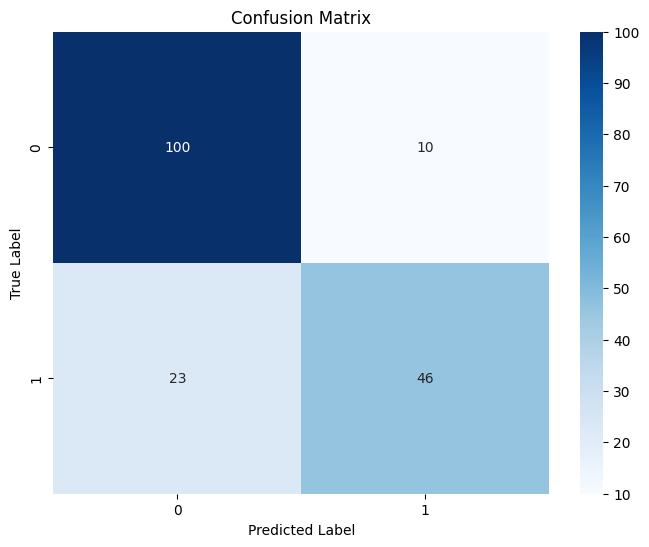

In [74]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

Questa cella crea una matrice di confusione per valutare le performance del modello sul validation set.

- `confusion_matrix(y_val, y_pred)` calcola la matrice di confusione confrontando i valori reali (`y_val`) con le predizioni del modello (`y_pred`).
- `sns.heatmap()` visualizza la matrice con una mappa di colori (blu) e annotazioni numeriche per ogni cella.
- Gli assi rappresentano:
  - `True Label`: le etichette vere (righe)
  - `Predicted Label`: le etichette previste dal modello (colonne)
- La matrice permette di capire quanti casi sono stati classificati correttamente (diagonale) e quanti sono stati classificati erroneamente (fuori diagonale).

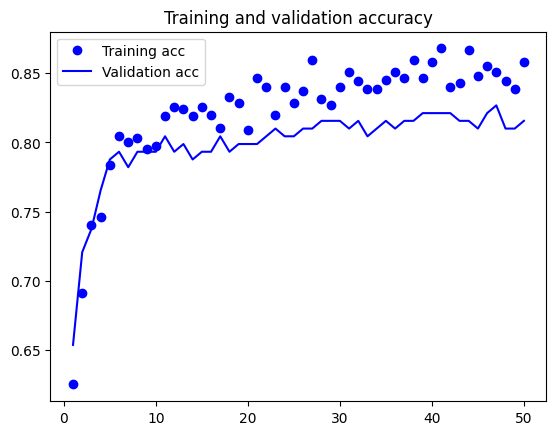

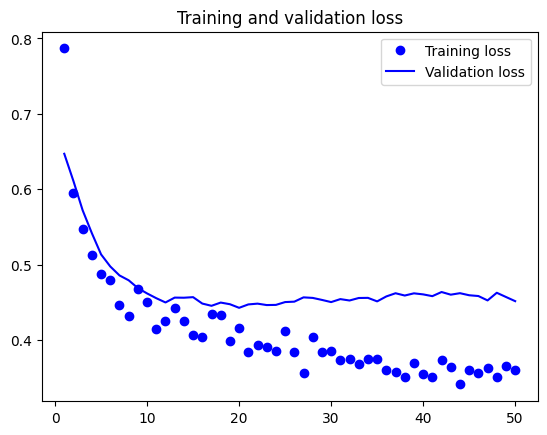

In [75]:
acc = history1.history["accuracy"]
val_acc = history1.history["val_accuracy"]
loss = history1.history["loss"]
val_loss = history1.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In questa cella vengono estratti e tracciati i valori di accuratezza (`accuracy`) e perdita (`loss`) dal processo di addestramento registrato in `history1`:

- `acc` e `val_acc` rappresentano rispettivamente l’accuratezza sul training set e sul validation set ad ogni epoca.
- `loss` e `val_loss` rappresentano la funzione di perdita (errori) su training e validation set ad ogni epoca.
- `epochs` definisce l’intervallo delle epoche per l’asse x.

Successivamente vengono creati due grafici:
1. **Training e validation accuracy**: mostra come l’accuratezza evolve durante le epoche, utile per capire se il modello sta migliorando e se c’è overfitting (quando l’accuratezza di training è molto più alta di quella di validation).
2. **Training e validation loss**: mostra come la perdita cambia durante l’addestramento, per valutare la convergenza del modello.


In [76]:
input_dim = X_train_scaled.shape[1]

model2 = keras.Sequential(
    [
        layers.Dense(128, activation="relu", input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(16, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        # Layer di output
        layers.Dense(1, activation="sigmoid"),
    ]
)

model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model2.summary()

C:\Users\Utente\Documents\ML\env\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 128)                 │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,065 (47.13 KB)

 Trainable params: 11,649 (45.50 KB)

 Non-trainable params: 416 (1.62 KB)

In [77]:
history2 = model2.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.5468 - loss: 0.8661 - val_accuracy: 0.7095 - val_loss: 0.6731
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5679 - loss: 0.7901 - val_accuracy: 0.6760 - val_loss: 0.6545
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6000 - loss: 0.7475 - val_accuracy: 0.6927 - val_loss: 0.6338
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6497 - loss: 0.6910 - val_accuracy: 0.6872 - val_loss: 0.6141
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6680 - loss: 0.6971 - val_accuracy: 0.6872 - val_loss: 0.5996
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6245 - loss: 0.7658 - val_accuracy: 0.7095 - val_loss: 0.5867
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6487 - loss: 0.7010 - val_accuracy: 0.7095 - val_loss: 0.5746
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6682 - loss: 0.6680 - val_accuracy: 0.7430 - v

Il secondo modello, model2, presenta alcune differenze chiave rispetto al primo modello, model1, che riflettono scelte progettuali volte a migliorare la capacità di generalizzazione e a ridurre il rischio di overfitting.

In particolare, model2 riduce il numero di neuroni nell’ultimo layer nascosto da 32 a 16, rendendo così la rete più compatta e meno complessa. Questa semplificazione aiuta a evitare che il modello impari troppo dettagli specifici del dataset di training, migliorando la sua capacità di adattarsi a dati nuovi.

Inoltre, il dropout nel primo layer viene aumentato dal 30% al 40%. Questo incremento nella regolarizzazione serve a disattivare casualmente più neuroni durante l’addestramento, riducendo la possibilità che il modello si “fissi” troppo su particolari pattern rumorosi o non generalizzabili.

Un’altra differenza importante riguarda il learning rate: model2 utilizza un valore più basso (0.0001 rispetto a 0.001). Ciò significa che i pesi vengono aggiornati più lentamente durante l’ottimizzazione, favorendo una convergenza più stabile e graduale, che può evitare oscillazioni e migliorare la performance finale.

Infine, entrambe le architetture mantengono l’uso di Batch Normalization in tutti i layer per stabilizzare e accelerare l’apprendimento.

In [78]:
y_pred_proba = model2.predict(X_val_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

# Metriche di valutazione
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(y_val, y_pred))

results["model2"] = accuracy

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Accuracy: 0.7933
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       110
           1       0.79      0.64      0.70        69

    accuracy                           0.79       179
   macro avg       0.79      0.76      0.77       179
weighted avg       0.79      0.79      0.79       179



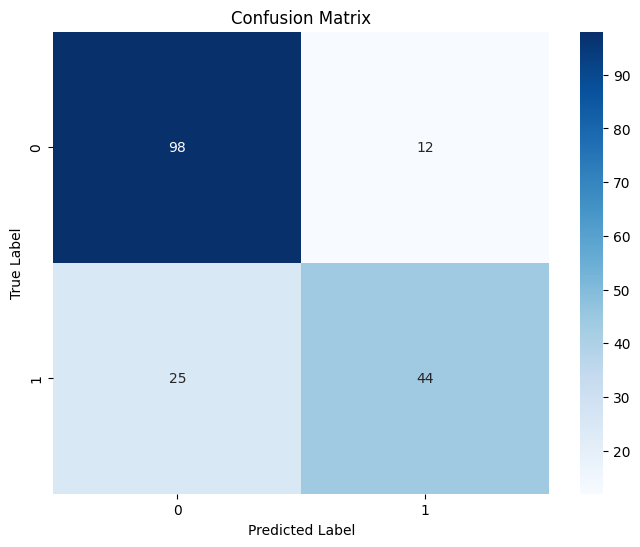

In [79]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

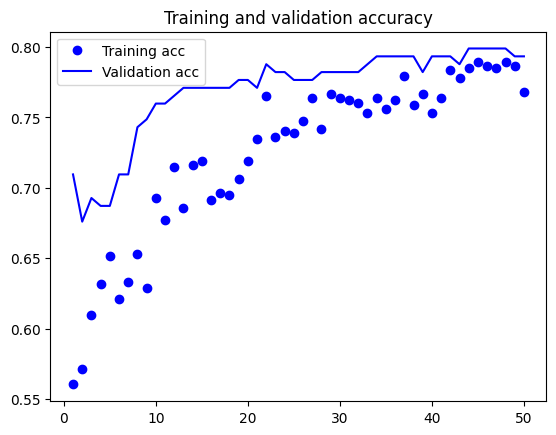

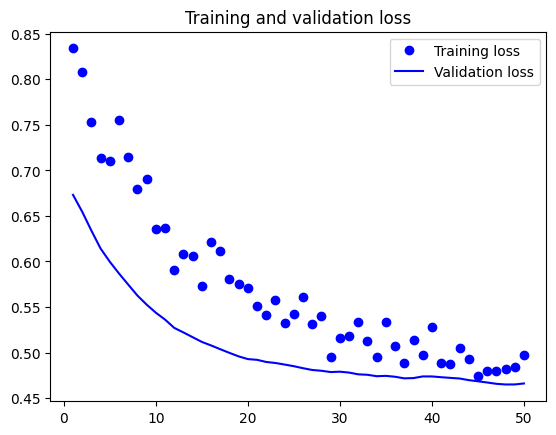

In [80]:
acc = history2.history["accuracy"]
val_acc = history2.history["val_accuracy"]
loss = history2.history["loss"]
val_loss = history2.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [81]:
input_dim = X_train_scaled.shape[1]

model3 = keras.Sequential(
    [
        layers.Dense(256, activation="relu", input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        # Layer di output
        layers.Dense(1, activation="sigmoid"),
    ]
)

model3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model3.summary()

C:\Users\Utente\Documents\ML\env\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                     │ (None, 256)                 │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,849 (183.00 KB)

 Trainable params: 45,953 (179.50 KB)

 Non-trainable params: 896 (3.50 KB)

In [82]:
history3 = model3.fit(
    X_train_scaled,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.5839 - loss: 0.8473 - val_accuracy: 0.6536 - val_loss: 0.6667
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6865 - loss: 0.6488 - val_accuracy: 0.6592 - val_loss: 0.6429
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6868 - loss: 0.6237 - val_accuracy: 0.6648 - val_loss: 0.6204
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7013 - loss: 0.6190 - val_accuracy: 0.7039 - val_loss: 0.5997
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7744 - loss: 0.5077 - val_accuracy: 0.7318 - val_loss: 0.5763
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7804 - loss: 0.5232 - val_accuracy: 0.7598 - val_loss: 0.5566
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7606 - loss: 0.4907 - val_accuracy: 0.7765 - val_loss: 0.5355
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7786 - loss: 0.5244 - val_accuracy: 0.7821 - v

Il modello 3 (model3) presenta una rete più profonda e più ampia rispetto al modello 2 (model2), con l’obiettivo di aumentare la capacità di apprendimento del modello.

In particolare, model3 introduce un primo layer nascosto con 256 neuroni, rispetto ai 128 di model2, e un secondo layer con 128 neuroni invece di 64. Questo incremento nel numero di neuroni permette al modello di catturare pattern più complessi e dettagliati dai dati.

Il terzo layer invece, con 32 neuroni, è simile a quello di model1 e maggiore rispetto ai 16 neuroni di model2, quindi più capace di rappresentare informazioni complesse prima del layer di output.

Tuttavia, nonostante la maggiore complessità, model3 mantiene un dropout uniforme al 20% in tutti i layer per prevenire l’overfitting, ma con un’intensità inferiore rispetto al 40% di dropout nel primo layer di model2. Questo compromesso mira a bilanciare la maggiore capacità del modello con la necessità di regolarizzazione.

Il learning rate rimane basso (0.0001), come in model2, per favorire una convergenza stabile e graduale.

In [83]:
y_pred_proba = model3.predict(X_val_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

# Metriche di valutazione
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(y_val, y_pred))

results["model3"] = accuracy

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Accuracy: 0.8324
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       110
           1       0.88      0.65      0.75        69

    accuracy                           0.83       179
   macro avg       0.85      0.80      0.81       179
weighted avg       0.84      0.83      0.83       179



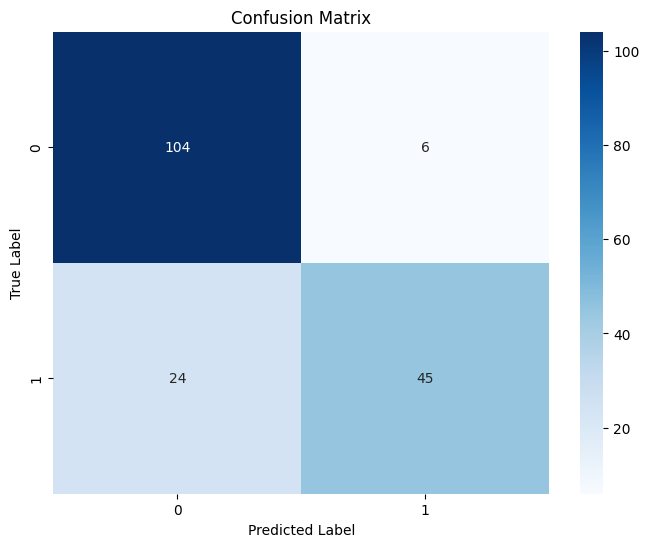

In [84]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

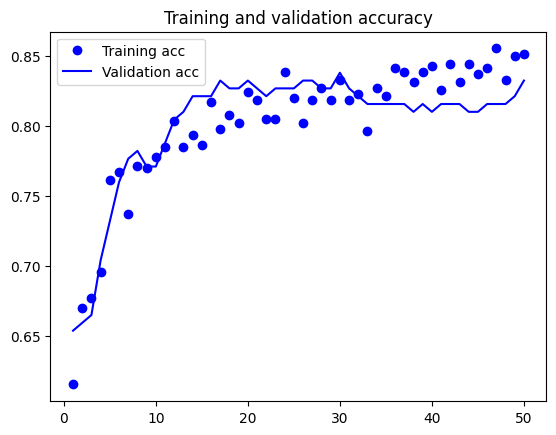

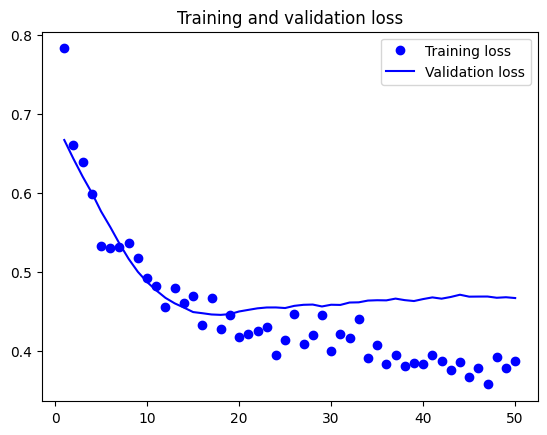

In [85]:
acc = history3.history["accuracy"]
val_acc = history3.history["val_accuracy"]
loss = history3.history["loss"]
val_loss = history3.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [86]:
for i in results:
    print(f"{i}: {results[i]:.4f}")

model1: 0.8156
model2: 0.7933
model3: 0.8324
